In [1]:
%load_ext autoreload
%autoreload 2

# Physics informed neural networks

This piece of code reproduces the work of [Raissi, Perdikaris, and Karniadakis on Physics Infomed Neural Networks](https://arxiv.org/pdf/1711.10561.pdf), applied to the Burgers' equation.

In [2]:
from matplotlib import pyplot as plt

from jaxdf.geometry import Domain
from jaxdf import operators as jops
from jaxdf.core import operator
from jax import numpy as jnp
import jax

In [3]:
domain = Domain(N=(200, 1000), dx=(0.01, 0.001)) # Domain is [space, time]

In [4]:
# Get samples for enforcing losses
domain_sampler = domain.domain_sampler
boundary_samples = domain.boundary_sampler

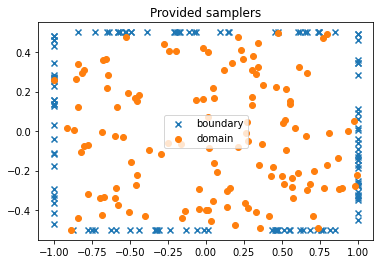

In [5]:
# Show example
boundary_sampler = domain.boundary_sampler
x = boundary_sampler(jax.random.PRNGKey(42), 128)
plt.scatter(x[:,0],x[:,1], marker='x', label="boundary")
x = domain_sampler(jax.random.PRNGKey(42), 128)
plt.scatter(x[:,0],x[:,1], marker='o', label="domain")
plt.legend()
plt.title("Provided samplers")
plt.show()

In [84]:
# Construct the PINN
from jaxdf.discretization import Arbitrary, UniformField
from jax.experimental import stax
from jax import random

seed = random.PRNGKey(42)

# Make a neural network for the field discretization
Tanh = stax.elementwise(jnp.tanh)
Layers = [stax.Dense(20), Tanh]*9
init_random_params, predict_p = stax.serial(*Layers, stax.Dense(1))

def init_params(seed, domain):
    return init_random_params(seed, (len(domain.N),))[1]

def get_fun(params, x):
    return predict_p(params, x)

u_discr = Arbitrary(domain, get_fun, init_params)
u_params, u = u_discr.random_field(seed, name='u')

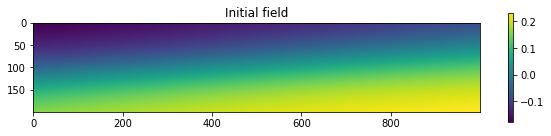

In [85]:
src_map = u_discr.get_field_on_grid()(u_params)
plt.figure(figsize=(10,2))
plt.imshow(src_map.real)
plt.colorbar()
plt.title("Initial field")
plt.show()

In [86]:
@operator()
def burgers(u):
    du_dt = jops.derivative(u, 1)
    du_dx = jops.derivative(u, 0)
    ddu_dx = jops.derivative(du_dx, 0)
    return -(0.01/jnp.pi)*ddu_dx + du_dx + du_dt

In [87]:
# Making operator numerical
num_op = burgers(u=u)
gp = num_op.get_global_params()
print(num_op)

DiscretizedOperator :: [Arbitrary], ['_x9'] 

 Input fields: ('u',)

Globals: Shared: {}
Independent: {'MultiplyScalar_p2': {'scalar': -0.003183098861837907}}

Operations:
- _k5: Arbitrary <-- ArbitraryDerivative ('u',) | (none) ArbitraryDerivative
- _mO: Arbitrary <-- ArbitraryDerivative ('u',) | (none) ArbitraryDerivative
- _oj: Arbitrary <-- ArbitraryDerivative ('_mO',) | (none) ArbitraryDerivative
- _q2: Arbitrary <-- MultiplyScalar ('_oj',) | (independent) MultiplyScalar_p2
- _vm: Arbitrary <-- AddField ('_q2', '_mO') | (none) AddField
- _x9: Arbitrary <-- AddField ('_vm', '_k5') | (none) AddField



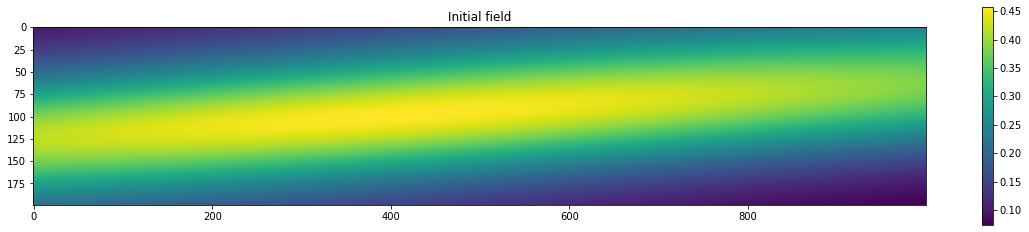

In [88]:
sample_burgers = num_op.get_field_on_grid(0)(gp, {"u": u_params})
plt.figure(figsize=(20,4))
plt.imshow(sample_burgers)
plt.colorbar()
plt.title("Initial field")
plt.show()

In [94]:
from functools import partial

sample_burgers = num_op.get_field(0)
batchsize = 128

def burgers_fun(params, x):
    return sample_burgers(gp, {"u": params}, x)

def field_fun(params, x):
    return u_discr.get_field()(params, x)

@partial(jax.jit, static_argnums=2)
def boundary_loss(params, seed, batchsize):
    x = boundary_sampler(seed, batchsize)
        
    # Initial conditions
    y = x.at[:,1].set(0.)
    field_val = jax.vmap(field_fun, in_axes=(None,0))(params, y)
    target_val = jnp.sin(jnp.pi*x[:,0])
    l1 = jnp.mean(jnp.abs(target_val - field_val)**2)
    
    # Boundaries
    y = x.at[:,0].set(random.bernoulli(seed, shape=(batchsize,))*2 - 1)
    field_val = jax.vmap(field_fun, in_axes=(None,0))(params, y)
    target_val = 0
    l2 = jnp.mean(jnp.abs(target_val - field_val)**2)
    
    return (l1 + l2)/2

@partial(jax.jit, static_argnums=2)
def domain_loss(params, seed, batchsize):
    x = domain_sampler(seed, batchsize)
    residual = jax.vmap(burgers_fun, in_axes=(None,0))(params, x)
    return jnp.mean(jnp.abs(residual)**2)


In [95]:
@jax.jit
def update(opt_state, seed, k):
    seeds = random.split(seed, 2)
    
    def tot_loss(params):
        l1 = domain_loss(params, seeds[0], batchsize)
        l2 = boundary_loss(params, seeds[1], batchsize)
        return 0.*l1 + l2
    
    lossval, grads = jax.value_and_grad(tot_loss)(get_params(opt_state))
    
    return lossval, update_fun(k, grads, opt_state)

In [101]:
from jax.experimental import optimizers

init_fun, update_fun, get_params = optimizers.adam(.000001)
opt_state = init_fun(u_params)

In [102]:
from tqdm import tqdm

pbar = tqdm(range(100000))
rng = seed

for k in pbar:
    rng, seed = random.split(rng,2)
    lossval, opt_state = update(opt_state, seed, k)
    
    if k % 100 == 99:
        pbar.set_description(f"Loss: {lossval}")

Loss: 0.15359407663345337:  10%| | 10105/100000 [00:37<05:29, 272.67it/s


KeyboardInterrupt: 

In [103]:
new_params = get_params(opt_state)

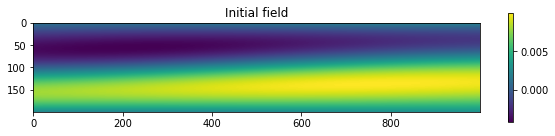

In [104]:
src_map = u_discr.get_field_on_grid()(new_params)
plt.figure(figsize=(10,2))
plt.imshow(src_map.real)
plt.colorbar()
plt.title("Initial field")
plt.show()

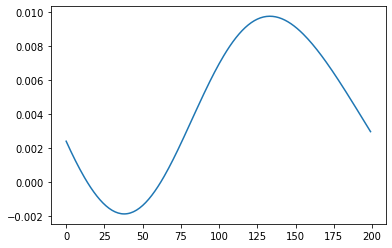

In [105]:
plt.plot(src_map[:,-1])